# ARIS-CH0 signal EDA

## Notebooks set-up

In [1]:
# Set notebook root to project root
from helper_functions import set_project_root

set_project_root()

# Standard library imports
import os
import random

# Third party imports
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Internal imports
import configuration as config

Working directory: /mnt/arkk/kaggle/ariel-data-challenge


## 1. Single planet

In [2]:
planets = list(os.listdir(f'{config.RAW_DATA_DIRECTORY}/train'))
random_planet = planets[random.randint(0, len(planets)-1)]
airs_file = f'{config.RAW_DATA_DIRECTORY}/train/{random_planet}/AIRS-CH0_signal_0.parquet'
print(f'Example AIRS-CH0 signal file path: {airs_file}')

Example AIRS-CH0 signal file path: ./data/raw/train/3280080364/AIRS-CH0_signal_0.parquet


In [3]:
# Read the Parquet file into a PyArrow Table
signal = pd.read_parquet(airs_file).to_numpy().reshape(11250, 32, 356)
print(f'Raw signal shape: {signal.shape}')
print(f'Raw frame shape: {signal[0].shape}')

Raw signal shape: (11250, 32, 356)
Raw frame shape: (32, 356)


In [4]:
# Crop the frames - see here: https://www.kaggle.com/code/gordonyip/calibrating-and-binning-ariel-data
cut_inf, cut_sup = 39, 321
signal = signal[:, :, cut_inf:cut_sup]
print(f'Cropped signal shape: {signal.shape}')
print(f'Cropped frame shape: {signal[0].shape}')

Cropped signal shape: (11250, 32, 282)
Cropped frame shape: (32, 282)


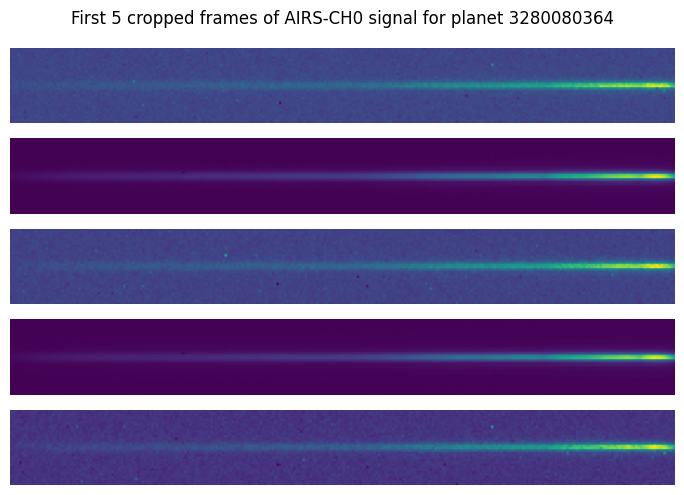

In [6]:
# Plot the first few frames
n_frames = 5
fig, axs = plt.subplots(n_frames, 1, figsize=(10, n_frames))
axs = axs.flatten()

fig.suptitle(f'First {n_frames} cropped frames of AIRS-CH0 signal for planet {random_planet}')

for i in range(n_frames):
    frame = signal[i]        
    frame = frame.astype(float) / np.mean(frame.astype(float))
    axs[i].imshow(frame)
    axs[i].axis('off')

fig.tight_layout()
fig.savefig('figures/EDA/01.3-AIRS_sample_frames.jpg', dpi=config.STD_FIG_DPI, bbox_inches='tight')

OK - I get it. Those smears are spectra - Ariel must put the signal through a grism or prism or something. Nice hint from the competition organizers about cropping the frames with `[:, :, 39:321]`, now we have a 1 to 1 correspondence between the pixels across the observed spectra and the wavelengths (though let's not assume no overlap..). One **more** hint they dropped in the [preprocessing notebook](https://www.kaggle.com/code/gordonyip/calibrating-and-binning-ariel-data) they shared is: '*Data reduction is crucial in astronomical observations*'. We should be able to isolate the 'strip' that contains the actual data. I also now understand why they included the guidance camera frames - it will probably make it much easier to spot exoplanet transits than trying to use these IR spectra smears.

Still not sure how exactly to get the uncertainties - some kind of bootstrapping probably.

Here's the tentative plan:

1. Figure out how to to efficiently spot transits in the FGS data.
2. Use transit info from FGS data to isolate transit spectral data from AIRS.
3. Use some kind of bootstrapping or ensemble method to learn the spectrum and get uncertainties.